# Common geometric operations

Geometric operations refer to a set of methods that can be used to process and analyze geometric features, like points, lines and polygons. In the context of geographic data analysis, these operations allow us, for instance, to ask questions about how two or more geographic objects relate to each other: Do they intersect, touch, or overlap? Are they adjacent to one another? How far apart are they? With the tools bundled in geopandas, it is easy to perform these kind of operations. As we delve into geometric operations, you'll discover they form the foundation of many geospatial analyses, enabling insights that are often difficult to discern from non-spatial data alone.

In the following, we demonstrate some of the most common geometric manipulation functions available in geopandas. We will do this by continuing to explore the census tract data from Austin, Texas. Geometric manipulations are often useful e.g. when working with data related to administrative boundaries, as we often might need to transform or manipulate the geographic data in one way or another for further analysis and visualization purposes. Next, we will learn how to generate centroids, different outlines and buffer zones for the polygons. Let's start by reading the census tract data into `GeoDataFrame`. In this case, we use data that we already manipulated a bit in the previous section (by calculating the area and population density):

In [2]:
import geopandas as gpd
from pathlib import Path

# Define path do the data
data_folder = Path("data/Austin")
fp = data_folder / "austin_pop_density_2019.gpkg"

# Read in the data and check the contents
data = gpd.read_file(fp)
data.head()

,pop2019,tract,area_km2,pop_density_km2,geometry
0,6070.0,002422,4.029772,1506.288778,"MULTIPOLYGON (((615643.488 3338728.496, 615645..."
1,2203.0,001751,1.532030,1437.961394,"MULTIPOLYGON (((618576.586 3359381.053, 618614..."
2,7419.0,002411,3.960344,1873.322161,"MULTIPOLYGON (((619200.163 3341784.654, 619270..."
3,4229.0,000401,2.181762,1938.341859,"MULTIPOLYGON (((621623.757 3350508.165, 621656..."
4,4589.0,002313,2.431208,1887.538658,"MULTIPOLYGON (((621630.247 3345130.744, 621717..."


For the purposes of geometric manipulations, we are mainly interested in the geometry column which contains the polygon geometries. Remember, that the data type of the geometry-column is `GeoSeries`. As we have mentioned earlier, the individual geometries are ultimately shapely geometric objects (e.g. `Point`, `LineString`, `Polygon`), and we can use all of shapely's tools for geometric manipulations directly via geopandas. The following shows that the geometries in the `GeoSeries` are stored as `MultiPolygon` objects:

In [11]:
data["geometry"].head()

0    MULTIPOLYGON (((615643.488 3338728.496, 615645...
1    MULTIPOLYGON (((618576.586 3359381.053, 618614...
2    MULTIPOLYGON (((619200.163 3341784.654, 619270...
3    MULTIPOLYGON (((621623.757 3350508.165, 621656...
4    MULTIPOLYGON (((621630.247 3345130.744, 621717...
Name: geometry, dtype: geometry

In [12]:
# Check data type of the geometry column
type(data["geometry"])

geopandas.geoseries.GeoSeries

In [13]:
# Check data type of a value in the geometry column
type(data["geometry"].values[0])

shapely.geometry.multipolygon.MultiPolygon

Let's first plot the original geometries. We can use the built-in `.plot()` function in geopandas to plot the geometries, and `matplotlib.pyplot` to turn off axis lines and labels:

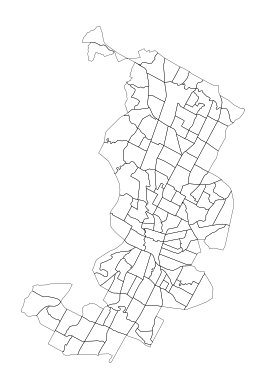

In [14]:
import matplotlib.pyplot as plt

data.plot(facecolor="none", linewidth=0.2)

plt.axis("off")
plt.show()

_**Figure 6.13**. Basic plot of the census tracts._

## Centroid

The centroid of a geometry is the geometric center of a given geometry (line, polygon or a geometry collection). Extracting the centroid of geometric features is useful in many cases. Geometric centroid can, for example, be used for locating text labels in visualizations. We can extract the center point of each polygon via the `centroid` attribute of the `geometry` column. The data should be in a projected coordinate reference system when calculating the centroids. If trying to calculate centroids based on latitude and longitude information, geopandas will warn us that the results are likely (slightly) incorrect. Our `GeoDataFrame` is in WGS 84 / UTM zone 14N (EPSG:32614) coordinate reference system (CRS) which is a projected one (we will learn more about these in the next section). Thus, we can directly proceed to calculating the centroids:

In [17]:
data.crs.name

'WGS 84 / UTM zone 14N'

In [18]:
data["geometry"].centroid.head()

0    POINT (616990.190 3339736.002)
1    POINT (619378.303 3359650.002)
2    POINT (620418.753 3342194.171)
3    POINT (622613.506 3351414.386)
4    POINT (622605.359 3343869.554)
dtype: geometry

We can also apply the method directly to the `GeoDataFrame` to achieve the same result using the syntax `data.centroid`. At the same time, we can also  plot the centroids for a visual check:

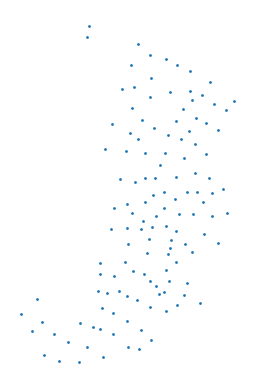

In [10]:
data.centroid.plot(markersize=1)

plt.axis("off")
plt.show()

_**Figure 6.14**. Basic plot of census tract centroids._

## Unary union

A unary union operation combines multiple geometric objects into a single, unified geometric shape. We can generate a joint outline for the administrative areas through creating a geometric union among all geometries. This can be useful, for example, for visualizing the outlines of a study area. The `.unary_union` returns a single geometry object, which is automatically visualized when running the code in a Jupyter Notebook:

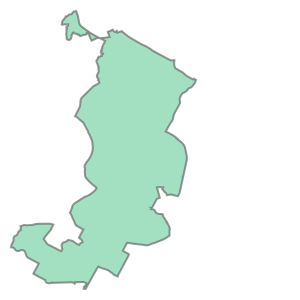

In [31]:
data.unary_union

_**Figure 6.15**. Union of all of census tract polygon geometries._

## Bounding polygon

A bounding polygon, often referred to as a bounding box or envelope, is the smallest rectangular polygon that encloses a given geometry or a set of geometries. In simpler terms, it's like drawing the tightest possible rectangle around a shape, capturing all of its points within this rectangle. The bounding polygon is often used in spatial operations for preliminary filtering because it provides a computationally simple way to test for possible intersections or proximities between geometries that can be used to select data. 

In a `GeoDataFrame`, we can easily return the minimum bounding rectangle of geometires by using the `envelope` attribute which returns the bounding rectangle for each geometry:

In [33]:
data.envelope.head()

0    POLYGON ((615643.488 3337909.895, 618358.033 3...
1    POLYGON ((618529.497 3358797.000, 620192.632 3...
2    POLYGON ((619198.456 3340875.421, 621733.880 3...
3    POLYGON ((621599.087 3350329.320, 623714.365 3...
4    POLYGON ((621630.247 3343015.679, 624133.189 3...
dtype: geometry

In order to get the bounding rectangle for the whole layer, we  first create an union of all geometries using `unary_union`, and then create the bounding rectangle for that polygon:

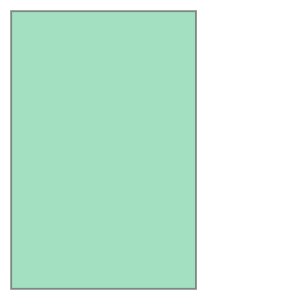

In [34]:
data.unary_union.envelope

_**Figure 6.16**. Minimum bounding box for the census tracts._

Corner coordinates of the bounding box for a `GeoDataFrame` can be fetched via the `total_bounds` attribute: 

In [15]:
data.total_bounds

array([ 608125.39434001, 3337909.89495403,  629828.38846075,
       3370513.6825782 ])

The `bounds` attribute returns the bounding coordinates of each feature:

In [16]:
data.bounds.head()

,minx,miny,maxx,maxy
0,615643.487492,3.337910e+06,618358.032738,3.341257e+06
1,618529.497100,3.358797e+06,620192.631882,3.360614e+06
2,619198.455980,3.340875e+06,621733.879615,3.343443e+06
3,621599.086586,3.350329e+06,623714.365506,3.352436e+06
4,621630.247042,3.343016e+06,624133.188692,3.345131e+06


### Convex hull

A bit more detailed delineation of the data extent can be extracted using a convex hull which represents the smalles possible polygon that contains all points in an object. To illustrate this, imagine stretching a rubber band around a set of points. Once released, the rubber band would snap into the shape of the convex hull, which wraps around the outermost points. Thus, it excludes points that are "indentations" in the shape. In geocomputation, the convex hull is used for various tasks as it can be used to easily provide a simplified representation of a set of points or a more complex geometry. 

In geopandas, we can use an attribute `.convex_hull` to return the convex hull of geometries. Similarly as with unary union, if we apply the convex hull method on the whole `GeoDataFrame`, we will get a GeoSeries containing a convex hull for each polygon separately:

In [37]:
data.convex_hull.head()

0    POLYGON ((616870.883 3337909.895, 616852.964 3...
1    POLYGON ((619496.705 3358797.000, 618962.703 3...
2    POLYGON ((619848.500 3340875.421, 619811.394 3...
3    POLYGON ((622145.426 3350329.320, 622132.429 3...
4    POLYGON ((623931.770 3343015.679, 622426.307 3...
dtype: geometry

In order to create a convex hull for the whole extent, we need to first create an union of all polygons. 

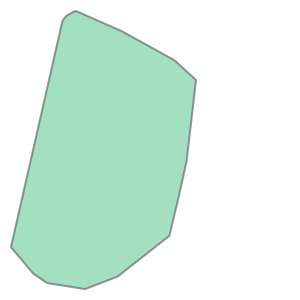

In [38]:
data.unary_union.convex_hull

_**Figure 6.17**. Smallest convex polygon for the census tracts._

### Concave hull

A concave hull is a polygon that encloses a set of points but, unlike the convex hull, is allowed to have concavities. In simpler terms, while a convex hull wraps around the outermost points in the tightest convex manner (like a stretched rubber band), a concave hull can bend inward to more closely follow the distribution of the points, providing a boundary that might be more representative of the actual shape of the dataset.

In geopandas, we can create a concave hull of a `GeoDataFrame` by calling `.concave_hull()` function. It works in a very similar manner as the previous examples, but because there are specific parameters that we can adjust, you need to add the parentheses `()` after the command. Again, if we apply the concave hull method on the whole `GeoDataFrame`, we will get a GeoSeries containing a concave hull for each polygon separately:

In [45]:
data.concave_hull().head()

0    POLYGON ((615643.488 3338728.496, 615645.477 3...
1    POLYGON ((618656.138 3359225.519, 618529.497 3...
2    POLYGON ((619206.796 3341776.741, 619198.456 3...
3    POLYGON ((621749.395 3351388.631, 621744.108 3...
4    POLYGON ((621654.405 3344983.596, 621630.247 3...
dtype: geometry

If we want to return the concave hull for all geometries, we need to do a couple of tricks because this functionality does not come directly from shapely but is implemented only on geopandas. We first use `.unary_union` as before, but after this, we generate a `GeoDataFrame` out of this geometry, before calling the `concave_hull()` function:

<Axes: >

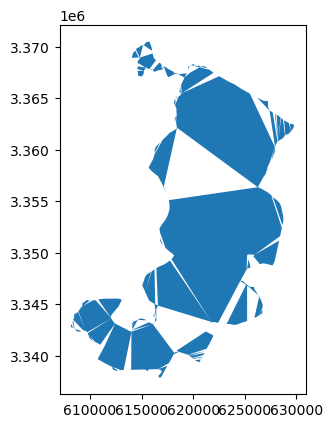

In [50]:
concave_hull = gpd.GeoDataFrame({"geometry": [data.unary_union]}).concave_hull()
concave_hull.plot()

As we can see, the exact shape of a concave hull has been simplified but the shape looks quite weird and has gaps between the shapes. Because calculating the concave hull is a much more complicated operation than the previous ones, there are actually a couple of parameters which we can use to control the shape of the output. Parameters `ratio` and `allow_holes` can be used in situations where the convex hull is too general or doesn't provide a realistic boundary for a set of points, like when capturing the outline of irregularly shaped clusters. In geopandas, the hull is constructed by removing border triangles of a process called Delaunay Triangulation of the points based on specific criteria. We can very easily improve the shape of the convex hull by adjusting the `ratio` parameter which accepts a value between 0.0 - 1.0. The higher the number, the fewer the number of vertices will be kept in the output. In the following, we can see how changing this value influences the end result. Let's first calculate the concave hull by passing different values for the `ratio` parameter:

In [75]:
# Create GeoDataFrame
gdf_union = gpd.GeoDataFrame({"geometry": [data.unary_union]})

# Ratio 0.05
concave_hull_a = gdf_union.concave_hull(ratio=0.05)

# Ratio 0.2
concave_hull_b = gdf_union.concave_hull(ratio=0.2)

# Ratio 0.4
concave_hull_c = gdf_union.concave_hull(ratio=0.4)

Now, let's plot these geometries side by side, so it is easy to compare them:

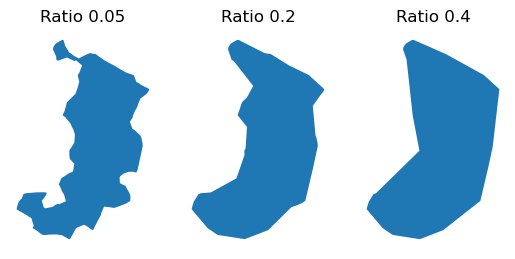

In [76]:
import matplotlib.pyplot as plt

# Create subplots 
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)

# Plot side by side
concave_hull_a.plot(ax=ax1)
concave_hull_b.plot(ax=ax2)
concave_hull_c.plot(ax=ax3)

# Remove axis
ax1.axis("off"); ax2.axis("off"); ax3.axis("off");

# Add titles
ax1.set_title("Ratio 0.05"); ax2.set_title("Ratio 0.2"); ax3.set_title("Ratio 0.4");

As we can see, by adjusting the `ratio` parameter, we can have a good control for determining how detailed geometries we get as an output.

## Simplifying geometries

Geometry simplification is a useful process especially when visualizing data that has very detailed geometry. With our sample data, we can generate simplified version of the outline extent. The tolerance parameter controls the level of simplification.

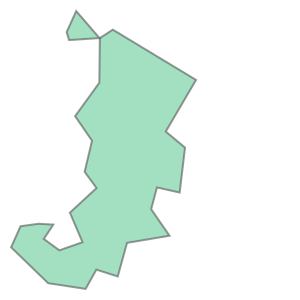

In [32]:
data.unary_union.simplify(tolerance=1000)

_**Figure 6.18**. Simplified union of the census tract polygons._

## Buffer

Buffering is a common spatial operation that has a multitude of use cases in spatial analyses. For example, in transport network analyses, it is good to fetch the transport network also from outside the study area in order to capture routes that go beyond the study area border. The distance parameter in the `buffer` function defines the radius or the buffer (according to the coordinate reference system of the data). Applying the buffer function on the entire data frame will produce separate buffers for each census tract.

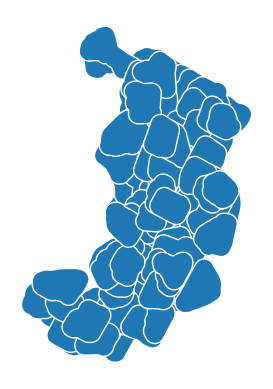

In [19]:
# 1000 m buffer for each polygon
data.buffer(1000).plot(edgecolor="white")

plt.axis("off")
plt.show()

_**Figure 6.19**. 1km buffer for each census tract._

If we want one buffer for the whole area, we first need to combine the geometries into one object before the buffer analysis. 

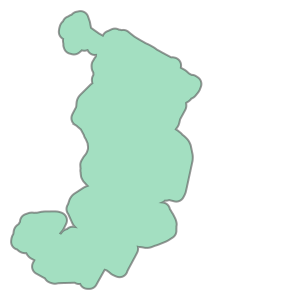

In [20]:
# 1000 m buffer for each polygon
data.unary_union.buffer(1000)

_**Figure 6.20**. 1km buffer for each census tract._

## Dissolving and merging geometries

Spatial data aggregation refers to combining geometries into coarser spatial units based on some attributes. The process may also include the calculation of summary statistics. 

In `pandas`, we learned how to group and aggregate data using the `groupby`method. In `geopandas`, there is a function called `dissolve()` that groups the data based on an anttribute column and unions the geometries for each group in that attribute. At the same time, we can also get summary statistics of the attributes. Read more about the details of the dissolve-function and related aggregation options in the `geopandas` [online documentation](https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html) [^gpd_dissolve].

To exceplify how dissolve works with our sample data, let's create create a new column to indicate census tracts with above average population density. We can do this by adding a new empty column `dense` and adding values that indicate above and below average population densities per census tract.

In [21]:
# Create a new column and add a constant value
data["dense"] = 0

In [22]:
# Filter rows with above average pop density and update the column dense
data.loc[data["pop_density_km2"] > data["pop_density_km2"].mean(), "dense"] = 1

In [23]:
# Check number of rows per category
data.dense.value_counts()

0    86
1    44
Name: dense, dtype: int64

Now we have a new column with value 1 indicating above average population density which we can use for dissolving the data into two groups using the `.dissolve()` funcition. At the same time, we can sum up the population and area columns valuens using the `aggfunc` parameter. The aggregation requires that we do a selection of the numerical columns we want to include in the output.

In [24]:
# Conduct the aggregation
dissolved = data[["pop2019", "area_km2", "dense", "geometry"]].dissolve(
    by="dense", aggfunc="sum"
)

In [25]:
# Check the result
dissolved

,geometry,pop2019,area_km2
dense,,,
0,"MULTIPOLYGON (((614108.230 3339640.551, 614288...",368992.0,231.131494
1,"MULTIPOLYGON (((612263.531 3338931.800, 612265...",242943.0,71.234570


The dissolved data should have as many rows of data as there were unique values in the column - one row for each unique value. Our data have been compressed into two geometric objects and the column used for dissolving the data can now be found in the index. Attribute columns represent the sum of the values per group. We can reset the index and insert the categorical information into a new column after which we can do a quick visualization of the result.

In [26]:
dissolved = dissolved.reset_index()

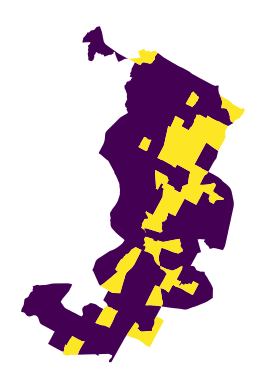

In [27]:
dissolved.plot(column="dense")

plt.axis("off")
plt.show()

_**Figure 6.21**. Dissolved census tract geometries._

## Updating the source for geometries in a GeoDataFrame

Before diving into other examples of geometric operations, let's discuss briefly about different ways to update the source column which is used to represent the geometries in your `GeoDataFrame`. In some cases, such as when calculating the centroids as we did earlier, you might actually want to save the centroids into your `GeoDataFrame` and continue processing or analysing the data based on these centroids. This can be done easily with geopandas, and there are a couple of approaches how to do this:

1. Overwrite the existing geometries in the `geometry` column by storing the new geometries into it.
2. Create a new column (e.g. `centroid`) and store the new geometries into this one. Then activate the column as the "source" for geometries in your `GeoDataFrame`. This means that you can have multiple simultaneous columns containing geometries in a `GeoDataFrame` which can be very handy!

Some important remarks about these approaches: The option 1 is very easy to do, but the downside of it is the fact that you do not have access to the original geometries (e.g. polygons) anymore. The option 2 requires a couple of steps, but the good side of it, is that you can easily swap between the original geometries and the centroids in your data. However, when saving the geographic data into disk, you can only include one column with geometries. Hence, latest at this stage, you need to decide which column is used for representing the geometric features in your data. In the following, we demonstrate how to do both of these. Let's start by showing how you can overwrite the existing geometries with centroids:

In [19]:
# Make a copy
option_1 = data.copy()

option_1["geometry"].head(2)

0    MULTIPOLYGON (((615643.488 3338728.496, 615645...
1    MULTIPOLYGON (((618576.586 3359381.053, 618614...
Name: geometry, dtype: geometry

In [21]:
# Update the geometry column with centroids
option_1["geometry"] = option_1.centroid

option_1.head(2)

,pop2019,tract,area_km2,pop_density_km2,geometry
0,6070.0,002422,4.029772,1506.288778,POINT (616990.190 3339736.002)
1,2203.0,001751,1.532030,1437.961394,POINT (619378.303 3359650.002)


As we can see, now the geometries in the `geometry` column were replaced and populated with `Point` objects that represent the centroids of the polygons. With this approach, you cannot anymore access the original polygon geometries.

The second option is to create a new column for storing the centroids and then use this column as the source for representing geometries of the given `GeoDataFrame`:

In [23]:
# Make a copy
option_2 = data.copy()

# Step 1: Create a column with centroids
option_2["centroid"] = data.centroid
option_2.head(2)

,pop2019,tract,area_km2,pop_density_km2,geometry,centroid
0,6070.0,002422,4.029772,1506.288778,"MULTIPOLYGON (((615643.488 3338728.496, 615645...",POINT (616990.190 3339736.002)
1,2203.0,001751,1.532030,1437.961394,"MULTIPOLYGON (((618576.586 3359381.053, 618614...",POINT (619378.303 3359650.002)


Now we have two columns in our `GeoDataFrame` that contain geometries. By default, geopandas always uses the `geometry` column as a source for representing the geometries. However, we can easily change this with `.set_geometry()` method which can be used to tell geopandas to use another column with geometries as the geometry-source:

In [25]:
# Use centroids as the GeoDataFrame geometries
option2 = option_2.set_geometry("centroid")
option2.head(2)

,pop2019,tract,area_km2,pop_density_km2,geometry,centroid
0,6070.0,002422,4.029772,1506.288778,"MULTIPOLYGON (((615643.488 3338728.496, 615645...",POINT (616990.190 3339736.002)
1,2203.0,001751,1.532030,1437.961394,"MULTIPOLYGON (((618576.586 3359381.053, 618614...",POINT (619378.303 3359650.002)


Nothing seem to have changed in the data itself, which is good because we did not want to modify any data. However, when we take a look at the `.geometry.name` attribute of the `GeoDataFrame`, we can see that the name of the column used for representing geometries has actually changed:

In [30]:
option2.geometry.name

'centroid'

We can still confirm this by plotting our `GeoDataFrame` which now returns a map with points:

<Axes: >

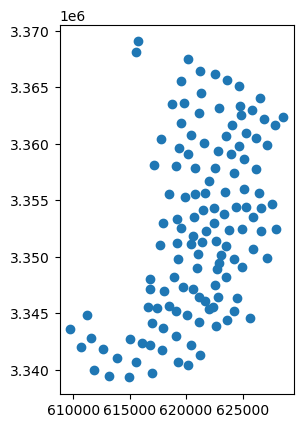

In [28]:
option2.plot()

By following this approach, you can easily change the active `geometry` for your `GeoDataFrame` based on data stored in different columns. This can be highly useful when manipulating geometries as you can store the geometries from different computational steps into a same `GeoDataFrame` without a need to make multiple copies of the data. However, we recommend to be a bit careful when storing multiple columns with geometries, as it is possible that you accidentally use a different source for geometries than what you have planned to do, which can cause confusion and problems with your analyses. Always remember the name the columns intuitively which can help avoiding issues and confusion in your analyses!

## Footnotes

[^gpd_dissolve]: <https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html>